## Load libraries

In [11]:
import os
import logging

import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

from alphai_watson.performance import GANPerformanceAnalysis
from alphai_watson.transformer import NullTransformer
from alphai_rickandmorty_oracle.datasource.kddcup99 import KDDCup99DataSource
from alphai_rickandmorty_oracle.detective import RickAndMortyDetective
from alphai_rickandmorty_oracle.model import RickAndMorty

from alphai_rickandmorty_oracle.architecture.kddcup99 import KDDCup99GanArchitecture

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

%matplotlib inline


## Define KDDCup99 Datasource

In [2]:
file_path = '../../tests/resources'
data_filename = os.path.join(file_path, 'kddcup.data_10_percent_corrected')
header_filename = os.path.join(file_path, 'kddcup.names')

kdd_datasource = KDDCup99DataSource(source_file=data_filename,
                                    header_file=header_filename,
                                    transformer=NullTransformer(8, 8))

data_normal_train = kdd_datasource.get_train_data('NORMAL')
data_normal_test = kdd_datasource.get_train_data('NORMAL_TEST')
data_abnormal_test = kdd_datasource.get_train_data('ABNORMAL_TEST')

## Define Model

In [3]:
model_dir = './kddcup99_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

batch_size = 64
output_dimensions = 121
plot_dimensions = (11, 11)
train_iters = 10000
plot_save_path = model_dir

architecture = KDDCup99GanArchitecture(output_dimensions, plot_dimensions)

model = RickAndMorty(architecture=architecture,
                     batch_size=batch_size,
                     train_iters=train_iters,
                     plot_save_path=plot_save_path)

detective = RickAndMortyDetective(model_configuration={
    'model': model,
    'batch_size': model.batch_size,
    'output_dimensions': model.architecture.output_dimensions,
    'save_path' : '{}/KDDCup99-model'.format(model_dir),
    'plot_save_path': plot_save_path
    
})

### Train

iter 0	time	0.1614377498626709	train disc cost	1.3860293626785278
iter 1	time	0.07238912582397461	train gen cost	0.692787230014801	train disc cost	1.3853847980499268
iter 2	time	0.04796433448791504	train gen cost	0.6929605007171631	train disc cost	1.3844897747039795
iter 3	time	0.04822230339050293	train gen cost	0.6930270195007324	train disc cost	1.3831044435501099
iter 4	time	0.047234535217285156	train gen cost	0.6931390762329102	train disc cost	1.381138801574707
iter 99	time	0.043907935995804635	train gen cost	1.651161551475525	train disc cost	0.684401273727417
iter 199	time	0.03984177350997925	train gen cost	7.570549488067627	train disc cost	0.2782647907733917
iter 299	time	0.04151731491088867	train gen cost	8.699026107788086	train disc cost	0.277592271566391
iter 399	time	0.03912517070770263	train gen cost	6.639991283416748	train disc cost	0.28433167934417725
iter 499	time	0.03844497203826904	train gen cost	3.354050397872925	train disc cost	0.3915041387081146
iter 599	time	0.042874

iter 7599	time	0.04218001365661621	train gen cost	1.8980151414871216	train disc cost	0.616926908493042
iter 7699	time	0.03498279809951782	train gen cost	1.8103374242782593	train disc cost	0.6166359186172485
iter 7799	time	0.04383810520172119	train gen cost	1.816474199295044	train disc cost	0.6295531988143921
iter 7899	time	0.03479266166687012	train gen cost	1.8112279176712036	train disc cost	0.6539417505264282
iter 7999	time	0.0428199052810669	train gen cost	1.799439549446106	train disc cost	0.6550685167312622
iter 8099	time	0.034642951488494875	train gen cost	1.766390323638916	train disc cost	0.6762335300445557
iter 8199	time	0.04397894144058227	train gen cost	1.7550925016403198	train disc cost	0.6702620983123779
iter 8299	time	0.035123014450073244	train gen cost	1.732102632522583	train disc cost	0.7028312683105469
iter 8399	time	0.042665328979492184	train gen cost	1.7000819444656372	train disc cost	0.7233832478523254
iter 8499	time	0.03570051670074463	train gen cost	1.673014998435974

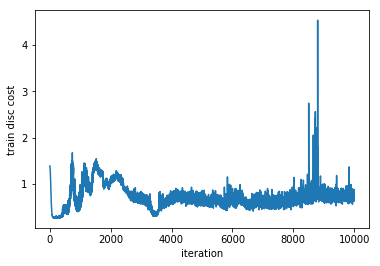

In [4]:
detective.train(data_normal_train)

### Plot cost curves

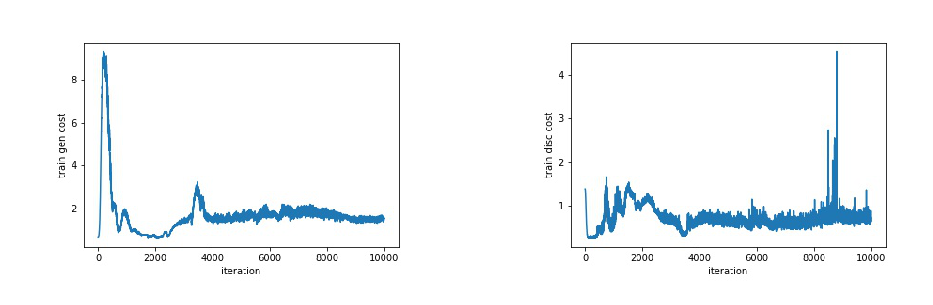

In [15]:
gen_cost_img = mpimg.imread(os.path.join(plot_save_path, 'train_gen_cost.jpg'))
disc_cost_img = mpimg.imread(os.path.join(plot_save_path, 'train_disc_cost.jpg'))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.imshow(gen_cost_img);
ax1.axis('off');
ax2.imshow(disc_cost_img);
ax2.axis('off');

## Evaluate results
***

### Visualise generated samples

In [ ]:
n_row = 4
n_col = 8

plt.figure(figsize=(2*n_col, 2*n_row))

gs = gridspec.GridSpec(n_row, n_col)
gs.update(wspace=0.025, hspace=0.05)

generated_samples = detective.model.generate_fake_samples()

for i in range(n_row * n_col):
    ax = plt.subplot(gs[i])
    ax.axis('off')
    ax.imshow(generated_samples[i], cmap='gray')

### Collate ground truth

In [ ]:
n1 = np.ones(len(data_normal_test.data))
n2 = np.zeros(len(data_abnormal_test.data))

ground_truth = np.hstack((n1, n2))

### Collate detection results

In [ ]:
test_results_normal = detective.detect(data_normal_test).data 
test_results_abnormal = detective.detect(data_abnormal_test).data 

predictions = np.hstack((test_results_normal, test_results_abnormal))

### Calculate ROC Score

In [ ]:
roc_score = GANPerformanceAnalysis({}).analyse(
  detection_result=predictions,
  expected_truth=ground_truth
)

print('ROC Score: {}'.format(roc_score))

### Calculate training accuracy

In [ ]:
def model_accuracy(data, status, threshold=None):
    results = detective.detect(data).data 
    if threshold is None:
        threshold = np.median(results)
    ground_truth = [status] * len(results)
    prediction = [1 if x >= threshold else 0 for x in results]
    print('Accuracy: {0:.2f}%'.format(100*accuracy_score(ground_truth, prediction)))
    return threshold

In [ ]:
threshold = model_accuracy(data_normal_train, 1)

### Generate classification report

In [ ]:
class_predictions = [1 if x >= threshold else 0 for x in predictions]

target_names = ['ABNORMAL', 'NORMAL']
print(classification_report(ground_truth, class_predictions, target_names=target_names))

## Root Cause Analysis

In [ ]:
n_img = 4

normal_test_samples = \
    test_data_normal.data[np.random.choice(test_data_normal.data.shape[0], n_img, replace=False), :, :]
abnormal_test_samples = \
    test_data_abnormal.data[np.random.choice(test_data_abnormal.data.shape[0], n_img, replace=False), :, :]

normal_best_fakes = [detective.diagnose(nor_img) for nor_img in normal_test_samples]
abnormal_best_fakes = [detective.diagnose(abn_img) for abn_img in abnormal_test_samples]

# Plot normal class
fig, ax = plt.subplots(3, n_img, figsize=(16, 12))
fig.suptitle('Normal class', fontsize=28)
ax[0, 0].set_ylabel('Real', fontsize=20)
ax[1, 0].set_ylabel('Best fake', fontsize=20)
ax[2, 0].set_ylabel('Squared Distance', fontsize=20)

for i in range(n_img):
    ax[0, i].imshow(normal_test_samples[i], cmap='gray'); 
    ax[1, i].imshow(normal_best_fakes[i], cmap='gray')
    ax[2, i].imshow(np.square(normal_test_samples[i] - normal_best_fakes[i]), cmap='YlOrRd', vmin=0, vmax=1)

# Plot abnormal class
fig, ax = plt.subplots(3, n_img, figsize=(16, 12))
fig.suptitle('Abnormal class', fontsize=28)
ax[0, 0].set_ylabel('Real', fontsize=20)
ax[1, 0].set_ylabel('Best fake', fontsize=20)
ax[2, 0].set_ylabel('Squared Distance', fontsize=20)

for i in range(n_img):
    ax[0, i].imshow(abnormal_test_samples[i], cmap='gray'); 
    ax[1, i].imshow(abnormal_best_fakes[i], cmap='gray')
    ax[2, i].imshow(np.square(abnormal_test_samples[i] - abnormal_best_fakes[i]), cmap='YlOrRd', vmin=0, vmax=1)